**BAN427 INSURANCE ANALYTICS, EXAM 2022**

*Students: Greta Miotto and Louis Rodriguez*

**[0. Preparatory work](#heading--0)**

**[1. Analysis of churn patterns](#heading--1)**

  * [1.1. Full churn](#heading--1-1)
    * [1.1.1. Descriptive analysis](#heading--1-1-1)
    * [1.1.2. Decision Tree and Regression](#heading--1-1-2)
    * [1.1.3. Models: Logistic regression](#heading--1-1-3)
      * [Model Evaluation](#heading--1-1-3-1)
    * [1.1.4. Models: Random Forest](#heading--1-1-4)
      * [Model Evaluation](#heading--1-1-4-1)
    * [1.1.5. Models: GBM](#heading--1-1-5)
      * [Model Evaluation](#heading--1-1-5-1)
    * [1.1.6. Recommended Model](#heading--1-1-6)

  * [1.2. Partial churn](#heading--1-2)
    * [1.2.1. Descriptive analysis](#heading--1-2-1)
    * [1.2.2. Decision Tree Model](#heading--1-2-2)

  * [1.3. Love you calls exercise](#heading--1-3)

  * [1.4. Model production](#heading--1-4)

**[2. Analysis of AB test](#heading--2)**

  * [2.1. Scenarios allocation](#heading--2-1)
  * [2.2. Significant variables](#heading--2-2)
  * [2.3. Advices](#heading--2-3)
  * [2.4. Other outcomes](#heading--2-4)



# Preparatory work <a name="heading--0"/>

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import scipy.stats as stats
import pylab as pl
import warnings
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
import pickle
import statsmodels.api as sm
import os as os
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source 
import pydotplus
import pydot
from six import StringIO  
from IPython.display import Image
import shap
import graphviz

In [ ]:
%matplotlib inline
import matplotlib as mpl

# Analysis of churn patterns <a name="heading--1"/>

In [ ]:
pwd

'/content'

In [ ]:
df1 = pd.read_excel('exam_case_data.xlsx')
df1.head()

,TIME1,TIME2,TENURE_TIME1,TENURE_TIME2,AGE,WOMAN,NUMBER_COVERS_TIME1,NUMBER_COVERS_TIME2,TOTAL_PREM_TIME1,TOTAL_PREM_TIME2,HAVE_CAR_AT_TIME1,CHILD_INSURANCE_AT_TIME1,TRAVEL_INSURANCE_AT_TIME1,HOUSE_INSURANCE_AT_TIME1,CLAIM_EVENT_BEFORE_TIME1,PARTNER_CUSTOMER_TIME1,AVERAGE_INCOME_COUNTY_TIME1
0,1,2.0,1.8,2.3,62,1,17,20.0,6379,8222.0,1,0,0,1,1,1,NaN
1,1,2.0,1.5,2.0,35,1,1,1.0,232,297.0,0,0,0,0,0,1,266400.0
2,1,2.0,5.7,6.2,69,0,8,8.0,3279,3761.0,1,0,1,1,0,0,NaN
3,1,2.0,13.1,13.6,83,0,12,12.0,8133,8133.0,1,0,1,1,1,0,NaN
4,1,2.0,17.4,17.9,43,1,22,22.0,15074,17252.0,1,0,1,1,1,1,NaN


Adding two columns and deleting useless ones:

FULL is a binary column that identifies full churners;

PARTIAL is a binary column that identifies partial churners.

In [ ]:
#Adding 

df1['FULL'] = np.where(df1['TIME2']!= 2, 1, 0)
df1['PARTIAL'] = np.where((df1["NUMBER_COVERS_TIME1"] >= df1["NUMBER_COVERS_TIME2"]) & (df1['FULL'] != 1), 1, 0)

#Dropping NaNs

df1=df1.dropna(subset=['AGE', 'WOMAN', 'TENURE_TIME1', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 
                       'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1',
                       'HOUSE_INSURANCE_AT_TIME1', 'CLAIM_EVENT_BEFORE_TIME1', 
                       'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1'])

In [ ]:
df1.describe()

,TIME1,TIME2,TENURE_TIME1,TENURE_TIME2,AGE,WOMAN,NUMBER_COVERS_TIME1,NUMBER_COVERS_TIME2,TOTAL_PREM_TIME1,TOTAL_PREM_TIME2,HAVE_CAR_AT_TIME1,CHILD_INSURANCE_AT_TIME1,TRAVEL_INSURANCE_AT_TIME1,HOUSE_INSURANCE_AT_TIME1,CLAIM_EVENT_BEFORE_TIME1,PARTNER_CUSTOMER_TIME1,AVERAGE_INCOME_COUNTY_TIME1,FULL,PARTIAL
count,19825.0,18576.0,19825.000000,18576.000000,19825.000000,19825.000000,19825.000000,18576.000000,19825.000000,18576.000000,19825.000000,19825.000000,19825.000000,19825.000000,19825.000000,19825.000000,19825.000000,19825.000000,19825.000000
mean,1.0,2.0,7.257120,7.842663,52.826683,0.410845,7.358487,7.395134,3661.612509,3736.842000,0.523480,0.100832,0.346532,0.380631,0.363884,0.738613,278445.185372,0.063001,0.823153
std,0.0,0.0,8.544205,8.521133,16.414916,0.492000,6.434117,6.294725,3307.796427,3367.803723,0.499461,0.301114,0.475877,0.485554,0.481128,0.439401,38751.207903,0.242971,0.381549
min,1.0,2.0,0.000000,0.000000,17.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156300.000000,0.000000,0.000000
25%,1.0,2.0,1.500000,2.000000,40.000000,0.000000,2.000000,3.000000,1095.000000,1231.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255400.000000,0.000000,1.000000
50%,1.0,2.0,3.300000,4.000000,52.000000,0.000000,5.000000,6.000000,2799.000000,2774.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,298300.000000,0.000000,1.000000
75%,1.0,2.0,11.300000,12.000000,65.000000,1.000000,11.000000,10.000000,5388.000000,5398.250000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,298300.000000,0.000000,1.000000
max,1.0,2.0,41.600000,42.100000,103.000000,1.000000,69.000000,65.000000,50804.000000,49465.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,341600.000000,1.000000,1.000000


## 1.1. Full churn <a name="heading--1-1"/>

### 1.1.1. Descriptive analysis <a name="heading--1-1-1"/>

In [ ]:
# Full churners are identified in the data as having missing TIME2 features.

df1_full = df1[df1["FULL"] == 1]
df1_full.describe()

,TIME1,TIME2,TENURE_TIME1,TENURE_TIME2,AGE,WOMAN,NUMBER_COVERS_TIME1,NUMBER_COVERS_TIME2,TOTAL_PREM_TIME1,TOTAL_PREM_TIME2,HAVE_CAR_AT_TIME1,CHILD_INSURANCE_AT_TIME1,TRAVEL_INSURANCE_AT_TIME1,HOUSE_INSURANCE_AT_TIME1,CLAIM_EVENT_BEFORE_TIME1,PARTNER_CUSTOMER_TIME1,AVERAGE_INCOME_COUNTY_TIME1,FULL,PARTIAL
count,1249.0,0.0,1249.000000,0.0,1249.000000,1249.000000,1249.000000,0.0,1249.000000,0.0,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.0,1249.0
mean,1.0,NaN,5.765572,NaN,49.841473,0.340272,5.385909,NaN,2936.484388,NaN,0.446757,0.044836,0.341873,0.252202,0.351481,0.643715,279050.040032,1.0,0.0
std,0.0,NaN,7.895374,NaN,18.656704,0.473990,5.432570,NaN,2859.257047,NaN,0.497356,0.207026,0.474527,0.434450,0.477624,0.479093,37548.364565,0.0,0.0
min,1.0,NaN,0.000000,NaN,19.000000,0.000000,1.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,158800.000000,1.0,0.0
25%,1.0,NaN,1.100000,NaN,34.000000,0.000000,2.000000,NaN,760.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,256500.000000,1.0,0.0
50%,1.0,NaN,2.400000,NaN,48.000000,0.000000,3.000000,NaN,1935.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,298300.000000,1.0,0.0
75%,1.0,NaN,7.000000,NaN,63.000000,1.000000,7.000000,NaN,4334.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,298300.000000,1.0,0.0
max,1.0,NaN,41.600000,NaN,98.000000,1.000000,34.000000,NaN,16694.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,341600.000000,1.0,0.0


In [ ]:
# Total number of observation is 19825, calculating the ratio of full churners

n_full = 1249/19825 

print("The ratio of full churners within the database is {}%". format(round(n_full * 100, 3)))

The ratio of full churners within the database is 6.3%


Full churners, that is rows with missing TIME2 features, are 1249 in this dataset. Their mean age is 50 years, 34% is female, 45% has a car and the rest of statistics can be seen from the table above.

### 1.1.2. Decision Tree and Regression <a name="heading--1-1-2"/>

In [ ]:
# Divide into target and features (should drop some features? try imputing)

df1 = df1.dropna(subset=['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 
                         'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 
                         'HOUSE_INSURANCE_AT_TIME1', 'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 
                         'AVERAGE_INCOME_COUNTY_TIME1'])

xdt1 = df1[['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 'HAVE_CAR_AT_TIME1', 
            'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 'HOUSE_INSURANCE_AT_TIME1', 
            'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1']]
ydt1 = df1[['FULL']]

regressor= DecisionTreeRegressor(random_state = 42, max_depth=3, min_samples_leaf=500)
regressor.fit(xdt1, ydt1)


DecisionTreeRegressor(max_depth=3, min_samples_leaf=500, random_state=42)

In [ ]:
dot_data = StringIO()

#looking at the tree
export_graphviz(regressor, out_file = dot_data, 
                feature_names=['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 'HAVE_CAR_AT_TIME1', 
                               'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 'HOUSE_INSURANCE_AT_TIME1', 
                               'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1'] ,
                filled=True, rounded=True, node_ids=True,
                special_characters=True)

<class 'pydotplus.graphviz.Dot'>


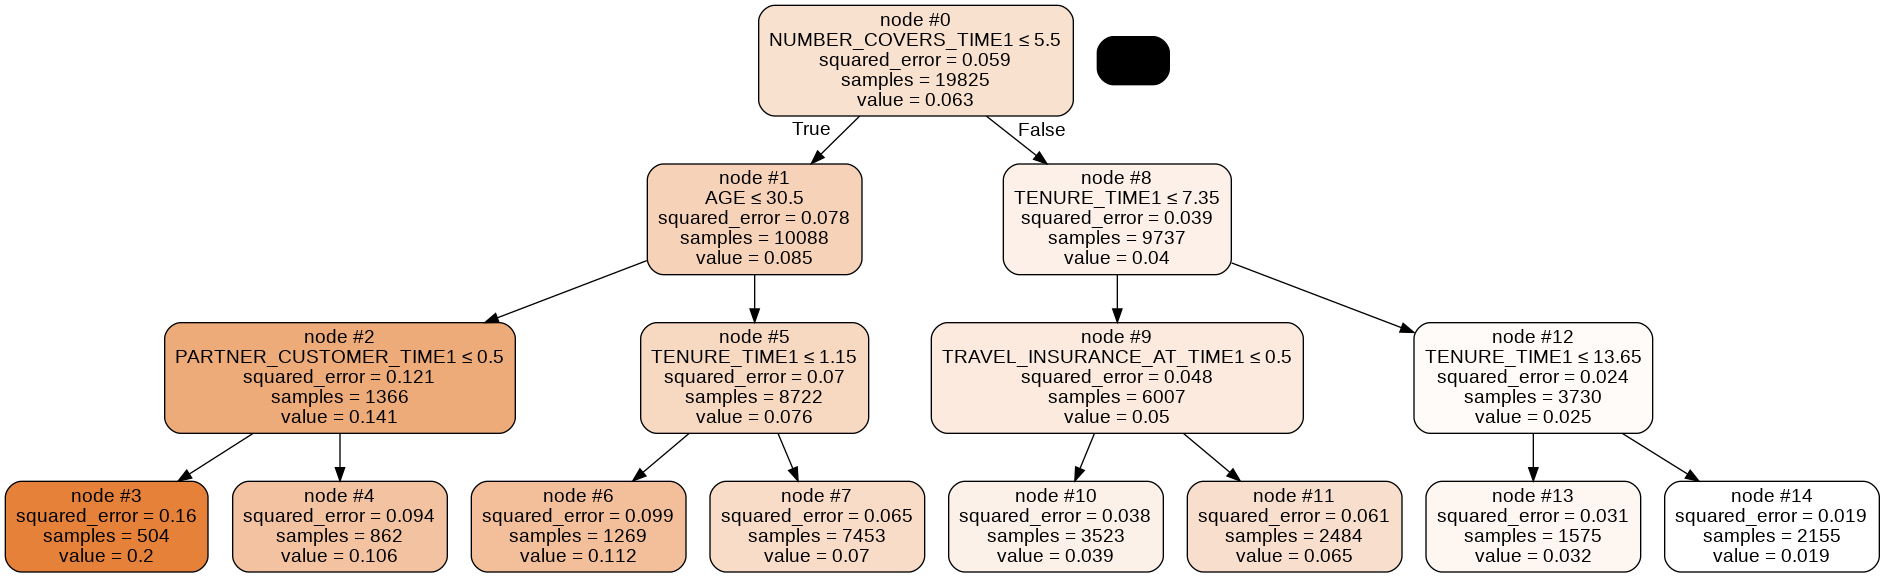

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print(type(graph))
print(graph)
Image(graph.create_png())

Little interpretation: for binary features 1 stands for yes and 0 stands for no that means if FEATURE_NAME <= 0.5 is True than the customer does not have this feature. 

In [ ]:
# We can also train a logit regression in order to find important features

import statsmodels.formula.api as smf
df_logit = df1[['FULL','AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 'HAVE_CAR_AT_TIME1', 
                'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 'HOUSE_INSURANCE_AT_TIME1', 
                'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1']]
mod = smf.logit(formula='FULL ~ AGE+TENURE_TIME1+WOMAN+NUMBER_COVERS_TIME1+TOTAL_PREM_TIME1+HAVE_CAR_AT_TIME1+CHILD_INSURANCE_AT_TIME1+TRAVEL_INSURANCE_AT_TIME1+HOUSE_INSURANCE_AT_TIME1+CLAIM_EVENT_BEFORE_TIME1+PARTNER_CUSTOMER_TIME1+ AVERAGE_INCOME_COUNTY_TIME1',data=df_logit)
result = mod.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.226020
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   FULL   No. Observations:                19825
Model:                          Logit   Df Residuals:                    19812
Method:                           MLE   Df Model:                           12
Date:                Wed, 31 Aug 2022   Pseudo R-squ.:                 0.03882
Time:                        08:45:19   Log-Likelihood:                -4480.8
converged:                       True   LL-Null:                       -4661.8
Covariance Type:            nonrobust   LLR p-value:                 4.320e-70
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.9877      0.255     -3.878      0.000   

Combining the outcome of the decision tree with the logit regression we can state that the **least** important features for FULL churn are (in order): Having a travel insurance at time 1, Having a car insurance at time 1 and the average income county at time1. These three features can be removed from the model.

Therefore, Car Insurance is not a driver for churn. Having a claim before time 1 is positively correlated to FULL churn since the coefficient is 0.2635 which means that customers with claims before time 1 are more likely to churn.

### 1.1.3. Prediction models: Logistic Regression <a name="heading--1-1-3"/>

In [ ]:
# Split data in test and train, drop NaN and useless columns

df1=df1.dropna(subset=['AGE', 'WOMAN', 'TENURE_TIME1', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 
                       'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 
                       'HOUSE_INSURANCE_AT_TIME1', 'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1'])
df1 = df1.drop(['TIME1', 'TIME2', 'TENURE_TIME2', 'NUMBER_COVERS_TIME2', 'TOTAL_PREM_TIME2'], axis=1)


df_train1, df_test1 = model_selection.train_test_split(df1, random_state=42, test_size=0.3)
print ('Train set has %d rows and %d columns' %df_train1.shape)
print ('Test set has %d rows and %d columns \n' % df_test1.shape) 

# It is important that the ratio is similar in train and test set.
print('FULL CHURN rate in train set is %.6f' %df_train1['FULL'].mean())
print('FULL CHURN rate in test set is %.6f' %df_test1['FULL'].mean())

Train set has 13877 rows and 14 columns
Test set has 5948 rows and 14 columns 

FULL CHURN rate in train set is 0.062910
FULL CHURN rate in test set is 0.063215


In [ ]:
# Define target and features

x_train1, y_train1 = df_train1.drop('FULL',axis=1), df_train1['FULL']
x_test1, y_test1 = df_test1.drop('FULL', axis = 1), df_test1['FULL']

In [ ]:
# Scaling using a Standard Scaler

from sklearn.preprocessing import StandardScaler
x_train_small1 = x_train1[['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 
                           'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 
                           'HOUSE_INSURANCE_AT_TIME1', 'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1']]
x_test_small1 = x_test1[['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 
                         'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 
                         'HOUSE_INSURANCE_AT_TIME1', 'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1']]
scaler = StandardScaler()
x_train_small_scaled1 = scaler.fit_transform(x_train_small1)
x_test_small_scaled1 = scaler.fit_transform(x_test_small1)

In [ ]:
# Train a logistic regression using the scaled features

logitregr = LogisticRegression(solver='liblinear')
logit_model = logitregr.fit(x_train_small_scaled1, y_train1)

In [ ]:
# Using SHAP values to explain the model

masker = shap.maskers.Independent(data=x_test_small_scaled1)
explainer_logit = shap.Explainer(logit_model, masker=masker, feature_names=x_train1.columns, algorithm="linear")
sv = explainer_logit(x_test_small_scaled1)
sv.base_values[0]

-2.9731755537113154

Shap values can be used to measure the impact of each feature on the predictions made by the algorithm. To do this, the shap.values_ function can be used, which takes in a matrix of feature values and outputs a matrix of shap values. Each row in the shap value matrix corresponds to a prediction, and each column corresponds to a feature. The shap values for a given prediction can be plotted using the shap.summary_plot function.

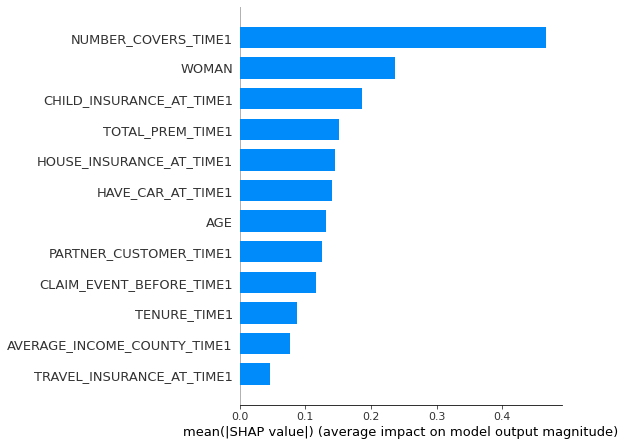

In [ ]:
# Some visualizations to understand the sharply impact of features

shap.summary_plot(sv, x_test_small_scaled1, plot_type="bar")

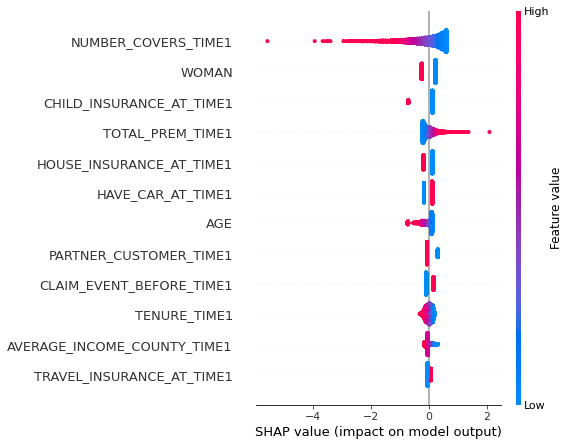

In [ ]:
shap.summary_plot(sv, x_test_small_scaled1)

There are a few things to look for when interpreting a shap violin summary plot:

1. The width of each "violin" represents the distribution of values for that feature. So a wider violin means that there is more variation in values for that feature.

2. The height of each violin represents the feature's importance. So a taller violin means that the feature is more important.


Low shap values which means low churn probability is highly correlated with the number of covers at time1. Let's have a look at the confusion matrix to understand whether the model is effectively working or not.

#### Model evaluation <a name="heading--1-1-3-1"/>

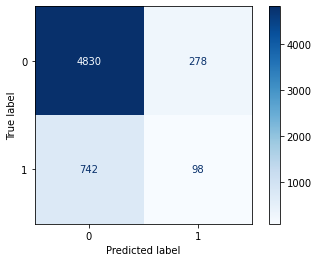

In [ ]:
# Confusion matrix (always using scaled x-features)
# Setting the threshold at 0.1 since 0.05 makes the model biased. 
# This is explained below, and for this reason we look at the ROC curve.

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

y_pred1 = (logit_model.predict_proba(x_test_small_scaled1)[:,1] >= 0.1).astype(bool)
cm1 = confusion_matrix(y_pred1, y_test1)
ConfusionMatrixDisplay(cm1, display_labels=['0','1']).plot(cmap=plt.cm.Blues)


Confusion matrix' scores depend on the threshold set which can change from case to case: if a threshold is set on the wrong level the model would classify all instances as 1 (or 0 for the opposite case) and the model would be biased and useless. For this reason it is better to check with other metrics.

Let's have a look at ROC curve which is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is defined as the number of true positives divided by the sum of the true positives and the false negatives. The false-positive rate is defined as the number of false positives divided by the sum of the false positives and the true negatives. Discrimination threshold settings are varied in order to generate a ROC curve.

In [ ]:
#Estimate and build the ROC curve

pred_prob = logit_model.predict_proba(x_test_small_scaled1)
fpr, tpr, tr = metrics.roc_curve(y_test1, pred_prob[:,1])
auc = metrics.roc_auc_score(y_test1, pred_prob[:, 1])
pred_prob1=logit_model.predict_proba(x_train_small_scaled1)
fpr1, tpr1, tr1 = metrics.roc_curve(y_train1, pred_prob1[:,1])
auc1 = metrics.roc_auc_score(y_train1, pred_prob1[:, 1])

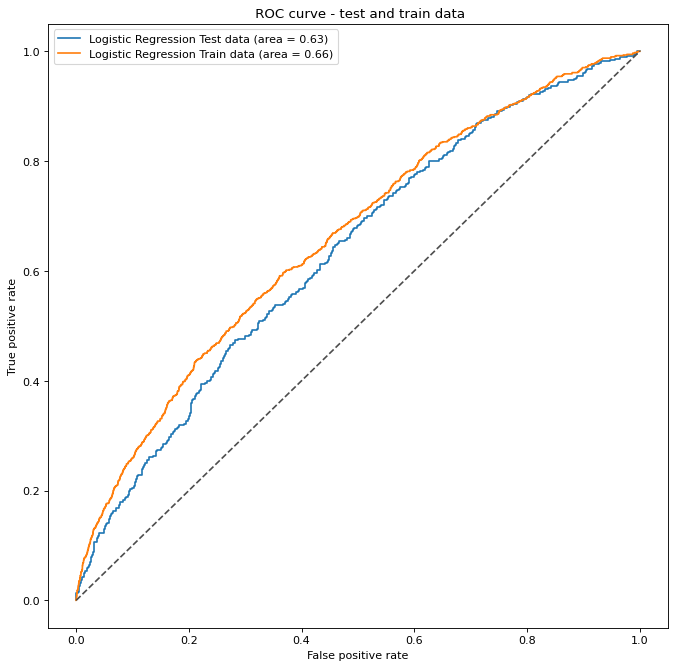

In [ ]:
# Plot the ROC curve

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.plot(fpr, tpr, label='Logistic Regression Test data (area = %0.2f)' % auc)
plt.plot(fpr1, tpr1, label='Logistic Regression Train data (area = %0.2f)' % auc1)
plt.plot((0, 1), (0, 1), ls = "--", c = ".3")
plt.title(' ROC curve - test and train data' )
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

This model is a good way to start the analysis as it is the simplest and most common model for binary variables. In this specific example it works with a ROC area score on test set equals to 0.63 which is not enough high so it is better to proceed with analysing other algorithms.

### 1.1.4. Prediction models: Random Forest <a name="heading--1-1-4"/>

In [ ]:
# Train a Random Forest model using non-scaled features

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state = 42, max_depth=3, min_samples_leaf=2000)
rf.fit(x_train_small1, y_train1)

RandomForestClassifier(max_depth=3, min_samples_leaf=2000, random_state=42)

In [ ]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(x_test_small1)

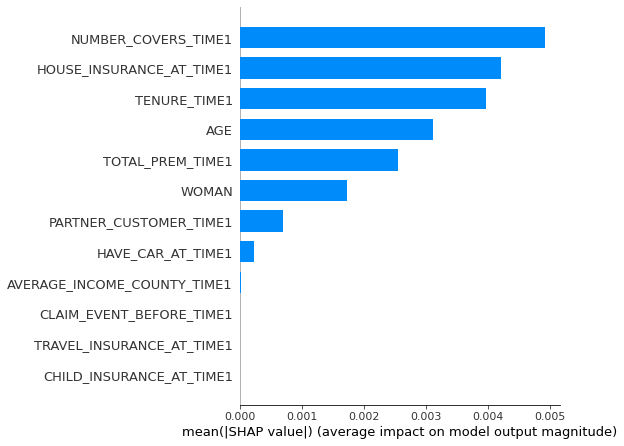

In [ ]:
shap.summary_plot(shap_values_rf[1], x_test_small1, plot_type = 'bar')

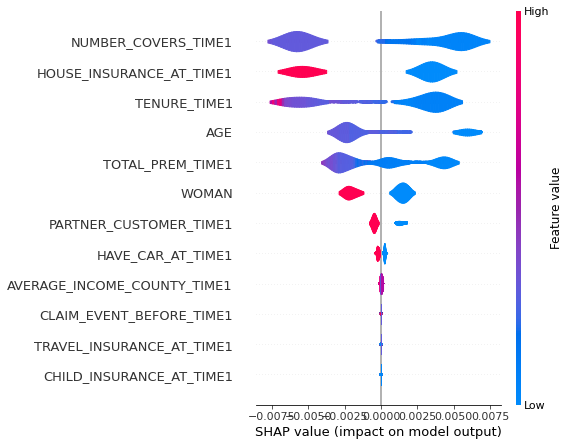

In [ ]:
shap.summary_plot(shap_values_rf[1], x_test_small1, plot_type='violin')

#### Model evaluation <a name="heading--1-1-4-1"/>

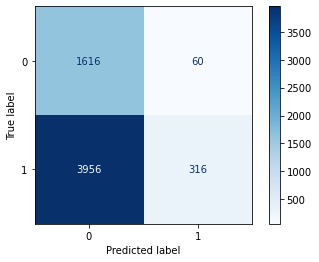

In [ ]:
# Build and plot the confusion matrix with a threshold of 0.05
# If the threshold is too high, the model would simply predict all values as Positive and it would be useless: explained above with the first model.

y_pred_rf_1 = (rf.predict_proba(x_test_small1)[:,1] >= 0.05).astype(bool)
cm2 = confusion_matrix(y_pred_rf_1, y_test1)
ConfusionMatrixDisplay(cm2, display_labels=['0','1']).plot(cmap=plt.cm.Blues)

In [ ]:
# Estimate and build the ROC curve, more trustworthy

pred_prob_rf = rf.predict_proba(x_test_small1)
fpr, tpr, tr = metrics.roc_curve(y_test1, pred_prob_rf[:,1])
auc = metrics.roc_auc_score(y_test1, pred_prob_rf[:, 1])
pred_prob_rf1= rf.predict_proba(x_train_small1)
fpr1, tpr1, tr1 = metrics.roc_curve(y_train1, pred_prob_rf1[:,1])
auc1 = metrics.roc_auc_score(y_train1, pred_prob_rf1[:, 1])

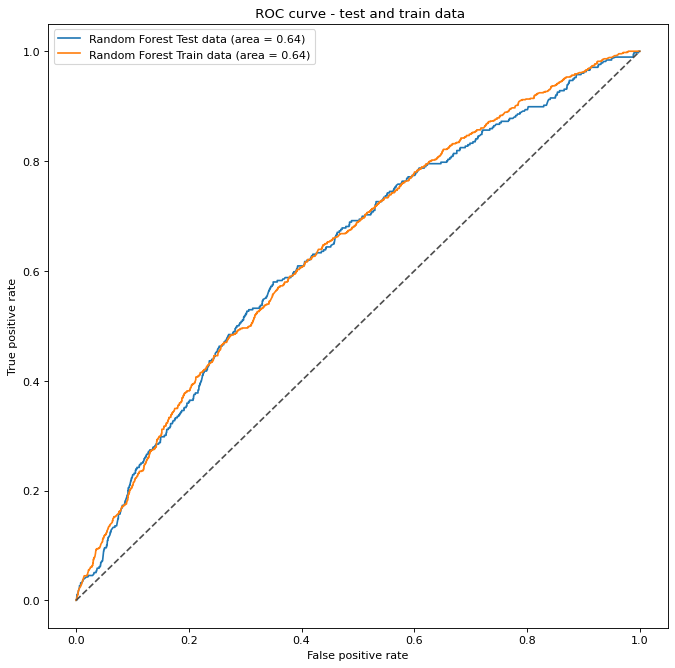

In [ ]:
# Plot the ROC curve

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.plot(fpr, tpr, label='Random Forest Test data (area = %0.2f)' % auc)
plt.plot(fpr1, tpr1, label='Random Forest Train data (area = %0.2f)' % auc1)
plt.plot((0, 1), (0, 1), ls = "--", c = ".3")
plt.title(' ROC curve - test and train data' )
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

Random forest is a machine learning algorithm that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. 

In this case the model does not seem to be strong on prediction as its test set area score is 0.64. It is better to try predicting with another algorithm. 

### 1.1.5. Prediction models: GBM <a name="heading--1-1-5"/>

In [ ]:
#Build and train the model

gbm = GradientBoostingClassifier(n_estimators = 100, max_depth = 4, min_samples_leaf = 500)
gbm = gbm.fit(x_train_small_scaled1, y_train1)

In [ ]:
# Explain the model 

masker = shap.maskers.Independent(data=x_test_small_scaled1)
explainer_gbm = shap.TreeExplainer(gbm, masker=masker, feature_names=x_train_small1.columns)
shap_values_gbm = explainer_gbm(x_test_small_scaled1)

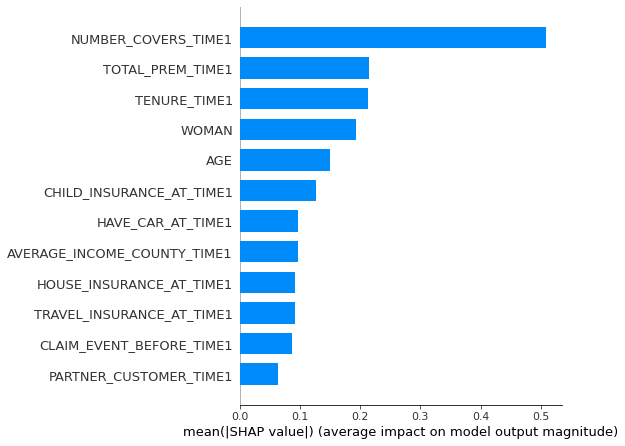

In [ ]:
shap.summary_plot(shap_values_gbm, x_test_small_scaled1, plot_type="bar")

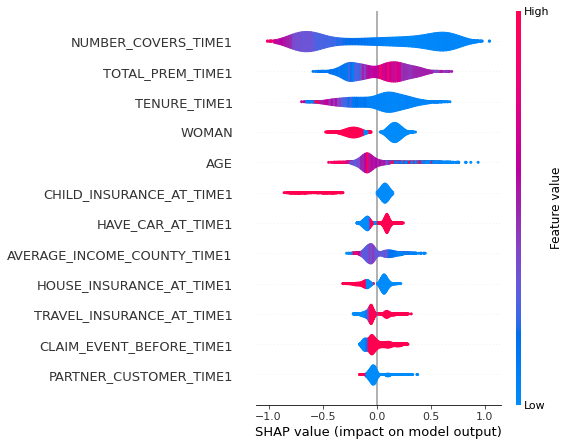

In [ ]:
shap.summary_plot(shap_values_gbm, x_test_small_scaled1, plot_type='violin')

#### Model evaluation <a name="heading--1-1-5-1"/>

X has feature names, but GradientBoostingClassifier was fitted without feature names


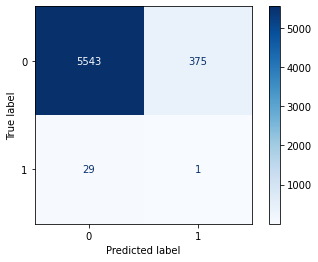

In [ ]:
# Confusion Matrix
# Setting the threshold at 0.04 since 0.05 is too low and the model predicts only True

y_pred_gbm_1 = (gbm.predict_proba(x_test_small1)[:,1] >= 0.04).astype(bool)
cm3 = confusion_matrix(y_pred_gbm_1, y_test1)
ConfusionMatrixDisplay(cm3, display_labels=['0','1']).plot(cmap=plt.cm.Blues)

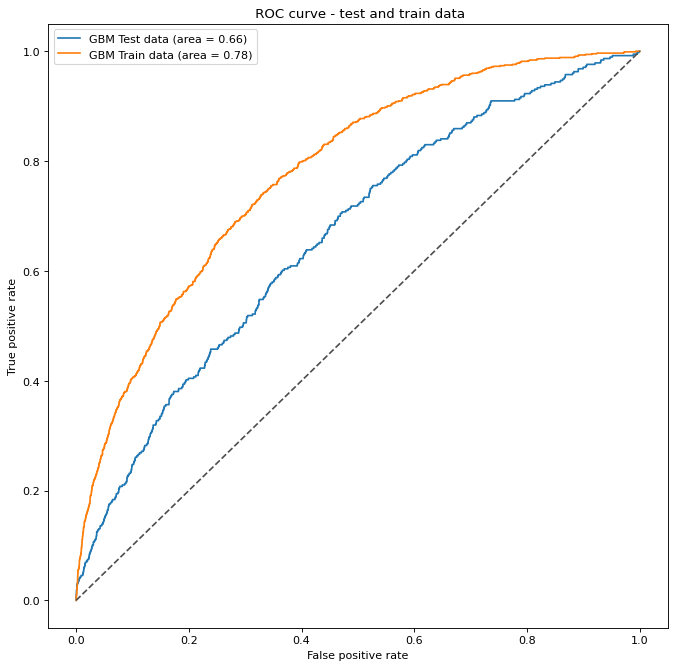

In [ ]:
#GBM ROC Curve

pred_prob = gbm.predict_proba(x_test_small_scaled1)
fpr, tpr, tr = metrics.roc_curve(y_test1, pred_prob[:,1])
auc = metrics.roc_auc_score(y_test1, pred_prob[:, 1])
pred_prob1 = gbm.predict_proba(x_train_small_scaled1)
fpr1, tpr1, tr = metrics.roc_curve(y_train1, pred_prob1[:,1])
auc1 = metrics.roc_auc_score(y_train1, pred_prob1[:, 1])

# plot roc curve
plt.figure(num = None, figsize=(10, 10), dpi=80)
plt.plot(fpr, tpr, label='GBM Test data (area = %0.2f)' % auc)
plt.plot(fpr1, tpr1, label='GBM Train data (area = %0.2f)' % auc1)
plt.plot((0, 1), (0, 1), ls = "--", c = ".3")
plt.title(' ROC curve - test and train data' )
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

A GBM model is an ensemble learning technique that combines multiple weak learners to create a strong learner. It works by sequentially adding weak learners to the model, until the model reaches a desired level of accuracy.



### 1.1.6. Recommended Model <a name="heading--1-1-6"/>

Compare ROC scores to choose the best model within the three models above. The highest the area is the better the model adapt to the set. To choose the best one we look at how well it predicts on the test set.

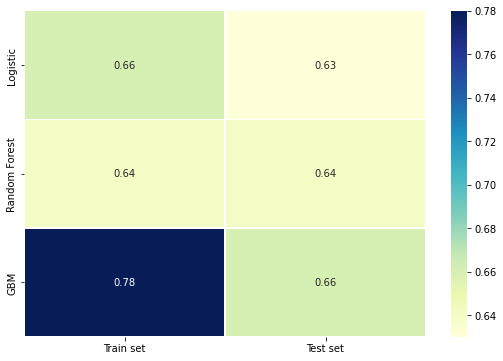

In [ ]:
# Compare ROC scores and visualize them with a heatmap

df_scores = pd.DataFrame({'Train set': [0.66 , 0.64, 0.78],
                          'Test set': [0.63, 0.64, 0.66]},
                         index = ['Logistic', 'Random Forest', 'GBM'] )

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_scores, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

From the heatmap above the best model seems to be the Gradient Boosting. In fact, the test set score is the highest (0.66) but the difference with the other two is not too high. It could be possible to try with other algorithms until we reach a higher level but as for now this result is enough. 

### Summarizing our analysis

The analysis started with a decision tree to have a first insight into the most important features and how to segment possible churners. A logistic regression helped into better understanding the p-value of these variables and the correlation (whether it is positive or negative) between the variable and the probability of a customer churning. 

Building some algorithm helped us minimize the variance in the prediction. A single decision tree is a weak predictor, but is relatively fast to build. More trees give you a more robust model and prevent overfitting. For this reason we built a Random Forest Classifier which is a combined set of decision trees. However, this model did not bring much improvement to our predictions. For this reason we tried training a Gradient Boosting Classifier. This is still a set of decision trees but differs from Random Forest by being based on Ensemble Learning. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners and combining results not at the end like RandomForest but during its way. This solution seemed to carry out the best result and therefore it is the model that we advise to implement.

## 1.2. Partial churn <a name="heading--1-2"/>

### 1.2.1. Descriptive analysis <a name="heading--1-2-1"/>

In [ ]:
df1.head()

,AGE,WOMAN,NUMBER_COVERS_TIME1,TOTAL_PREM_TIME1,HAVE_CAR_AT_TIME1,CHILD_INSURANCE_AT_TIME1,TRAVEL_INSURANCE_AT_TIME1,HOUSE_INSURANCE_AT_TIME1,CLAIM_EVENT_BEFORE_TIME1,PARTNER_CUSTOMER_TIME1,AVERAGE_INCOME_COUNTY_TIME1,FULL,PARTIAL
1,35,1,1,232,0,0,0,0,0,1,266400.0,0,1
5,80,0,17,4000,1,0,0,1,1,1,268300.0,0,1
15,40,0,3,769,1,0,0,0,0,1,238300.0,1,0
17,24,1,3,636,1,0,0,0,0,1,229000.0,0,1
21,37,1,7,2764,1,0,0,0,1,1,297200.0,0,1


In [ ]:
# Partial churners are identified as those customers who have decreased their number of covers from TIME1 to TIME2.

df1_par = df1[df1["PARTIAL"] == 1]
df1_par.describe()

,TENURE_TIME1,AGE,WOMAN,NUMBER_COVERS_TIME1,TOTAL_PREM_TIME1,HAVE_CAR_AT_TIME1,CHILD_INSURANCE_AT_TIME1,TRAVEL_INSURANCE_AT_TIME1,HOUSE_INSURANCE_AT_TIME1,CLAIM_EVENT_BEFORE_TIME1,PARTNER_CUSTOMER_TIME1,AVERAGE_INCOME_COUNTY_TIME1,FULL,PARTIAL
count,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.000000,16319.0,16319.0
mean,7.623923,53.406520,0.424536,7.400515,3678.398431,0.528893,0.103131,0.345242,0.382499,0.362890,0.741590,278527.575219,0.0,1.0
std,8.727532,16.430888,0.494287,6.371570,3311.556856,0.499180,0.304140,0.475462,0.486012,0.480848,0.437774,38783.627432,0.0,0.0
min,0.000000,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156300.000000,0.0,1.0
25%,1.500000,40.000000,0.000000,2.000000,1114.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255400.000000,0.0,1.0
50%,3.700000,52.000000,0.000000,6.000000,2850.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,298300.000000,0.0,1.0
75%,11.900000,66.000000,1.000000,11.000000,5406.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,298300.000000,0.0,1.0
max,41.600000,103.000000,1.000000,69.000000,50804.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,341600.000000,0.0,1.0


In [ ]:
# Total number of observation is 19825, calculating the ratio of partial churners

n_partial = 16319/19825 
print("The ratio of partial churners within the database is {}%". format(round(n_partial * 100, 3)))

The ratio of partial churners within the database is 82.315%


Partial churners are 16319. Mean age is 53 years old, 42% are women and other statistics are shown in the table above.

### 1.2.2. Decision Tree and Logistic Regression <a name="heading--1-2-2"/>

In [ ]:
# Divide into target and features
# Dropped features at time 2 since we are predicting from time1 to time 2

xdt2 = df1[['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 'TOTAL_PREM_TIME1', 'HAVE_CAR_AT_TIME1', 
            'CHILD_INSURANCE_AT_TIME1', 'TRAVEL_INSURANCE_AT_TIME1', 'HOUSE_INSURANCE_AT_TIME1', 
            'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1']]
ydt2 = df1[['PARTIAL']]

regressor= DecisionTreeRegressor(random_state = 42, max_depth=3, min_samples_leaf=500)
regressor.fit(xdt2, ydt2)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=500, random_state=42)

In [ ]:
dot_data = StringIO()

#looking at the tree
export_graphviz(regressor, out_file=dot_data, 
                feature_names=['AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1', 
                               'TOTAL_PREM_TIME1', 'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 
                               'TRAVEL_INSURANCE_AT_TIME1', 'HOUSE_INSURANCE_AT_TIME1', 
                               'CLAIM_EVENT_BEFORE_TIME1', 'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1'] ,
                filled=True, rounded=True,node_ids=True,
                special_characters=True)

<class 'pydotplus.graphviz.Dot'>


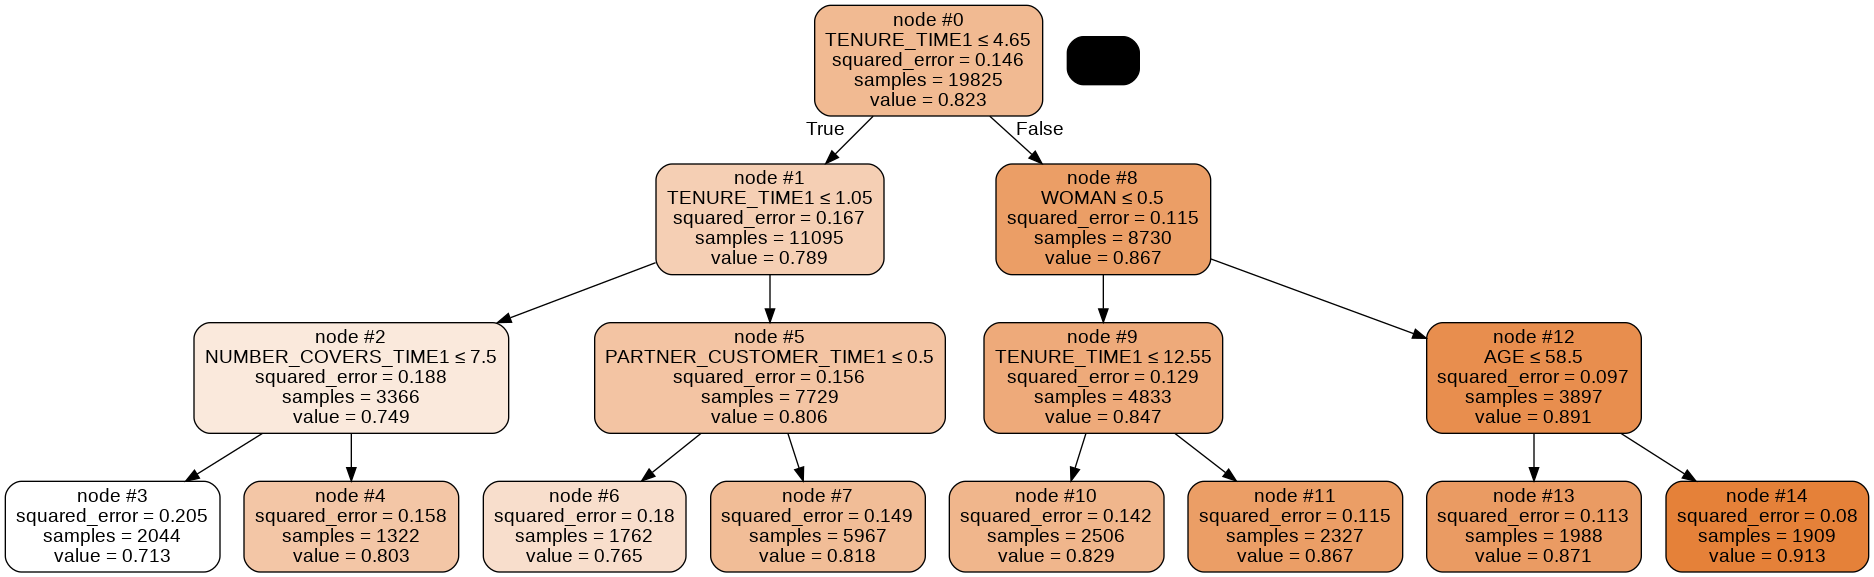

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print(type(graph))
print(graph)
Image(graph.create_png())

In [ ]:
# We can also train a logit regression in order to find important features

df_logit = df1[['PARTIAL','AGE', 'TENURE_TIME1', 'WOMAN', 'NUMBER_COVERS_TIME1',
                'TOTAL_PREM_TIME1', 'HAVE_CAR_AT_TIME1', 'CHILD_INSURANCE_AT_TIME1', 
                'TRAVEL_INSURANCE_AT_TIME1', 'HOUSE_INSURANCE_AT_TIME1', 'CLAIM_EVENT_BEFORE_TIME1',
                'PARTNER_CUSTOMER_TIME1', 'AVERAGE_INCOME_COUNTY_TIME1']]
mod2 = smf.logit(formula='PARTIAL ~ AGE+TENURE_TIME1+WOMAN+NUMBER_COVERS_TIME1+TOTAL_PREM_TIME1+HAVE_CAR_AT_TIME1+CHILD_INSURANCE_AT_TIME1+TRAVEL_INSURANCE_AT_TIME1+HOUSE_INSURANCE_AT_TIME1+CLAIM_EVENT_BEFORE_TIME1+PARTNER_CUSTOMER_TIME1+ AVERAGE_INCOME_COUNTY_TIME1',data=df_logit)
result2 = mod2.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.458016
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                PARTIAL   No. Observations:                19825
Model:                          Logit   Df Residuals:                    19812
Method:                           MLE   Df Model:                           12
Date:                Wed, 31 Aug 2022   Pseudo R-squ.:                 0.01835
Time:                        08:51:15   Log-Likelihood:                -9080.2
converged:                       True   LL-Null:                       -9249.9
Covariance Type:            nonrobust   LLR p-value:                 2.262e-65
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.3931      0.163      2.418      0.016   

The results we obtained with a Decision Tree and a Logit regression for Partial churners highlight that the **least** important features are: having a travel insurance at time 1, total premium at time 1, the number of covers at time 1, having a house insurance at time1 and the average income county at time 1.

Therefore, having a car at time 1 is slightly positevly correlated with partial churnes (p-value equals to 0.002). There is a negative weak correlation between being a partial churner and having claims before time 1 (coef = -0.1324 and pvalue = 0.002). 

## 1.3. Love you calls <a name="heading--1-3"/>


In [ ]:
# Define variables
handling_cost_per_call = 200
average_insurance_premium = 15000
average_claim_ratio = 0.7
percent_of_people_will_not_churn = 0.5
percent_of_people_will_churn = 0.5


In [ ]:
# Calculate expected profit 

# The average profit for each customer is: 4500 NOK
avg_prof = average_insurance_premium * (1 - average_claim_ratio)

# out of all the people called, 50% will churn anyway and out of the remaining an other 50% will churn (50% will not churn)

expected_profit = ((avg_prof * percent_of_people_will_churn) * percent_of_people_will_not_churn) - handling_cost_per_call

print("The expected profit for each 'love you call' is {} NOK.".format(round(expected_profit, 1)))

The expected profit for each 'love you call' is 925.0 NOK.


In [ ]:
# Calculating the break even point, which is the percentage of efficiency necessary for a profit=0

min_eff = (handling_cost_per_call / (avg_prof * percent_of_people_will_churn)) * 100

print("The minimum efficency percentage for a profit = 0 is {}%.".format(round(min_eff, 1)))

The minimum efficency percentage for a profit = 0 is 8.9%.


*Based on your calculation – what’s your advice to the manager – should she start the activity or not? Finally, are there some other considerations that you think will be important to highlight when you discuss this activity with the manager?*

Starting a campaign with so-called love you calls can bring the company additional profits, which can be measured especially in the long-run. In this particular example, given the data from the exercise, the campaign can be undertaken as long as the call's efficiency is above 8.9%, a threshold above which the company would make a loss. However, this action must be compared not only with other campaigns (e.g. mails, SMS) but also with the possibility of doing nothing. In the event that, after the campaign has started, it is noticed that the percentage of customers churning despite the 'love you calls' is not different from doing nothing, then it is better to stop the campaign and not waste 200NOK per call.




## 1.4. Model production <a name="heading--1-4"/>



These days training a model is not enough. To be successful, we also need to know how to put our model into production. 

First we train our model from an Analytical Base Table (ABT) we need data from multiple systems (For instance with a lot of tables of claims system with dbt which helps data teams to ship trusted data) and do a lot of ETL work. 
 
Next, we will need to package the model in an environment (container). 
We have a small model so we can use Gitlab. In general data are in JSON format. For instance, we can use this to censor a response from the fraud service. 

After that, we will need to validate the model by testing functional, technical, and possibly regulatory requirements. If we have a lot of data after a while, we could use Kubernetes in MS Azure. It is very useful for us because if the load increases (lots of claims), Kubernetes will spin up new containers. 

Finally, we will need to deploy the model with, for instance, Microsoft Azure. Once our model is up and running, we will need to monitor its behavior and performance and give a feedback loop to development. 

With the right steps, we can ensure that our model is ready for production.

This is a flow chart for the proposed production design : 

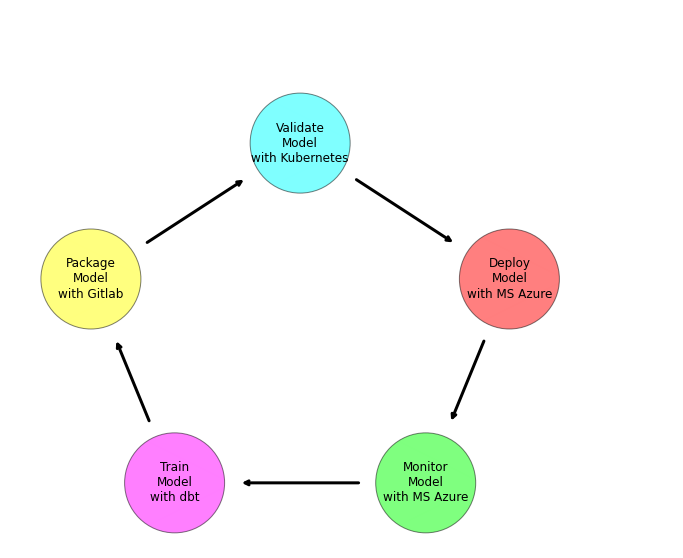

In [ ]:

import networkx as nx

plt.figure(figsize = (12,10))

From = ['Train\nModel\nwith dbt', 'Package\nModel\nwith Gitlab', 'Validate\nModel\nwith Kubernetes',
        "Deploy\nModel\nwith MS Azure","Monitor\nModel\nwith MS Azure"]
To = ["Package\nModel\nwith Gitlab", "Validate\nModel\nwith Kubernetes",
      "Deploy\nModel\nwith MS Azure",'Monitor\nModel\nwith MS Azure',"Train\nModel\nwith dbt"]

df = pd.DataFrame({ 'from':From,
                   'to':To})
# Define Node Positions
pos = {'Train\nModel\nwith dbt':(2,1),
        'Package\nModel\nwith Gitlab':(1,4),
        'Validate\nModel\nwith Kubernetes':(3.5,6),
        'Deploy\nModel\nwith MS Azure':(6,4),
        'Monitor\nModel\nwith MS Azure':(5,1)}

# Define Node Colors
NodeColors = {'Train\nModel\nwith dbt':[1,0,1],
        'Package\nModel\nwith Gitlab':[1,1,0],
        'Validate\nModel\nwith Kubernetes':[0,1,1],
        'Deploy\nModel\nwith MS Azure':[1,0,0],
        'Monitor\nModel\nwith MS Azure':[0,1,0]}

Labels = {}
i = 0
for a in From:
    Labels[a]=a
    i +=1
Labels[To[-1]]=To[-1]

# Build your graph. Note that we use the DiGraph function to create the graph! This adds arrows
G=nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph() )

# Define the colormap and set nodes to circles, but the last one to a triangle
Circles = []
Traingle = []
Colors_Circles = []
Colors_Traingle = []
for n in G.nodes:
        Circles.append(n)
        Colors_Circles.append(NodeColors[n])


# By making a white node that is larger, I can make the arrow "start" beyond the node
nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Circles,
                       node_size=1.25e4,
                       node_shape='>',
                       node_color='white',
                       alpha=1)

nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Circles,
                       node_size=1e4,
                       node_shape='o',
                       node_color=Colors_Circles,
                       edgecolors='black',
                       alpha=0.5)


nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Traingle,
                       node_size=1.25e4,
                       node_shape='o',
                       node_color='white',
                       alpha=1)

nodes = nx.draw_networkx_nodes(G, pos, 
                       nodelist = Traingle,
                       node_size=1e4,
                       node_shape='o',
                       node_color=Colors_Traingle,
                       edgecolors='black',
                       alpha=0.5)


nx.draw_networkx_labels(G, pos, Labels, font_size=12)

# Again by making the node_size larer, I can have the arrows end before they actually hit the node
edges = nx.draw_networkx_edges(G, pos, node_size=1.8e4,
                               arrowstyle='->',width=3)

plt.xlim(0,8)
plt.ylim(0,8)
plt.axis('off')
plt.show()

# AB testing <a name='heading--2'>

## 2.1. Scenarios allocation (a) <a name='heading--2-1'>

In [ ]:
# Reading the data
df2 = pd.read_csv("exam_ab_ex.csv")
df2.dtypes
df2.head()

,man,birthyear,claim,number_items_reported,Impression
0,0,1977,110.0,1,2.0
1,0,1987,12.0,1,2.0
2,1,1982,628.0,1,0.0
3,1,1968,503.6,1,0.0
4,1,1980,807.8,3,2.0


In [ ]:
df2['Impression'] = df2['Impression'] + 1
df2.head()

,man,birthyear,claim,number_items_reported,Impression
0,0,1977,110.0,1,3.0
1,0,1987,12.0,1,3.0
2,1,1982,628.0,1,1.0
3,1,1968,503.6,1,1.0
4,1,1980,807.8,3,3.0


In [ ]:
# Remove missing target and feature for this small feature set. Removing missing target is OK. 
df2 = df2.dropna()

# Start investigating the data
df2.Impression.describe()

count    1500.000000
mean        2.527333
std         1.129352
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Impression, dtype: float64

In [ ]:
# Looking at claims

df2.claim.describe()

count    1500.000000
mean      846.025333
std       845.400077
min         0.000000
25%       352.350000
50%       565.500000
75%      1000.000000
max      6900.000000
Name: claim, dtype: float64

We have altogether 1500 claim cases.

Average claim amount is around 846 (NOK?). 

In [ ]:
# Now we start to look if the Impression distribution is equal

pd.DataFrame(df2.groupby(['Impression'])['Impression'].count())
df_tab1=pd.crosstab(index=df2['Impression'],columns=['AGE'] ).rename(columns={'AGE':'Count'}).reset_index(drop=False)
df_tab1['Proportion']= df_tab1['Count'] / sum(df_tab1['Count'])
df_tab1

col_0,Impression,Count,Proportion
0,1.0,374,0.249333
1,2.0,356,0.237333
2,3.0,375,0.250000
3,4.0,395,0.263333


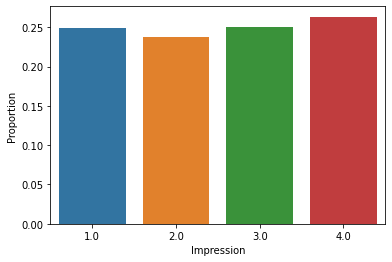

In [ ]:
# Plotting for easier visualization

sns.barplot(x = 'Impression', y = 'Proportion' ,data = df_tab1)

The DataSet is divided into 4 parts and each one is composed by almost 25% of the total. The split was correctly done. 

If we undertake a purely random allocation of individuals to different treatment (Impression 1) and control (Impression 2,3 and 4) – then we can measure average treatment effects – because groups will be equal on average. Therefore the available data is sufficient for our analysis.

## 2.2. Significant variables (b) <a name='heading--2-2'>

*Hypothesis : the claimant will adjust his/her claim depending on the impression given in the online tool. Do we find any statistically significant 
differences in the outcomes across the different impressions?*

In [ ]:
# First analysis: the average amount of claim grouped by impressions.
df2.claim.groupby(df2.Impression).mean()

Impression
1.0    911.253743
2.0    866.242697
3.0    791.260000
4.0    818.035949
Name: claim, dtype: float64

Text(0.5, 1.0, 'Claim size distribution according to the type of Impression')

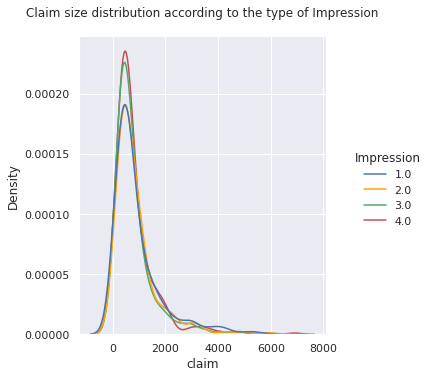

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.displot(data = df2, x = df2['claim'], hue = df2['Impression'], kind="kde", palette = ['b','orange','g','r'])

plt.title('Claim size distribution according to the type of Impression', pad=20)

In [ ]:
# Transforming the column Impression into four binary columns (dummy variables)

df2[['Impression1','Impression2','Impression3','Impression4']] = pd.get_dummies(df2['Impression'])
df2.head()

,man,birthyear,claim,number_items_reported,Impression,Impression1,Impression2,Impression3,Impression4
0,0,1977,110.0,1,3.0,0,0,1,0
1,0,1987,12.0,1,3.0,0,0,1,0
2,1,1982,628.0,1,1.0,1,0,0,0
3,1,1968,503.6,1,1.0,1,0,0,0
4,1,1980,807.8,3,3.0,0,0,1,0


In [ ]:
# Linear Regression with OLS method
import statsmodels.api as sm

x2 = sm.add_constant(df2[['Impression2','Impression3','Impression4']])
y2 = df2['claim']
lr = sm.OLS(y2,x2).fit()
lr.summary()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claim   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.480
Date:                Wed, 31 Aug 2022   Prob (F-statistic):              0.218
Time:                        19:09:54   Log-Likelihood:                -12235.
No. Observations:                1500   AIC:                         2.448e+04
Df Residuals:                    1496   BIC:                         2.450e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         911.2537     43.694     20.856      0.000     825.547     996.961
Impression2   -45.0110     62.568     -0.719      0.472    -167.742      77.720
Impression3  -119.9937     61.751     -1.943      0.052    -241.121       1.134
Impression4   -93.2178     60.965     -1.529      0.126    -212.804      26.369
==============================================================================
Omnibus:                      869.869   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7060.012
Skew:                           2.658   Prob(JB):                         0.00
Kurtosis:                      12.204   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Neither the 'Impression 2' (Neutral text – with more transparent explanations) or 'Impression 4' (A mild warning about not to “overreport” including a tick off box) scenario is statistically significant from baseline, computed with 'Impression 1'.On the other side, 'Impression 3' (A mild warning about not to “overreport”) is statistically significant at 10 %. 

In addition, 'Impression 3' has the lowest coefficient of regression  (-119.9937) which means that this impression has a real impact on claims.

The economic significance of 'Impression 3' and 'Impression 4' are, however,  large as can be observed from the previous graph. 

#### Gender

In [ ]:
# Average claim by gender

df2.claim.groupby(df2.man).mean()

man
0    777.131445
1    939.872913
Name: claim, dtype: float64

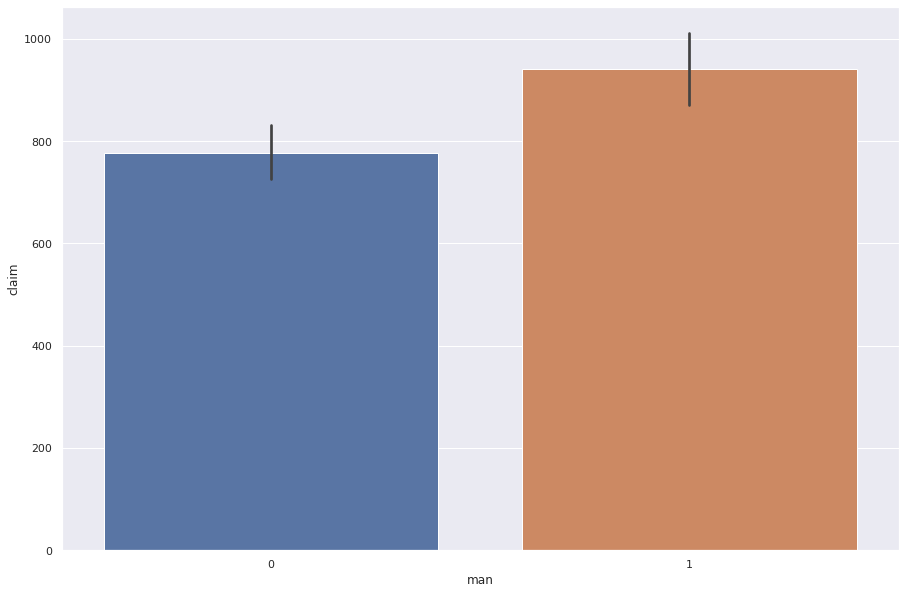

In [ ]:
sns.barplot(x='man', y='claim' ,data=df2)

Text(0.5, 1.0, 'Claim size distribution according to the gender')

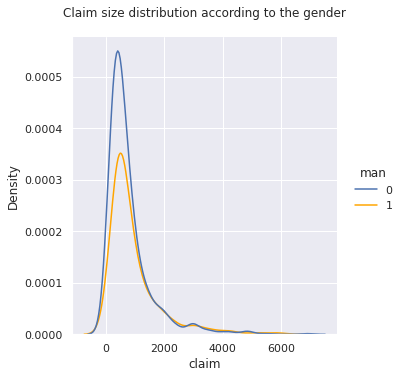

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(data=df2, x=df2['claim'], hue=df2['man'], kind="kde", palette = ['b','orange'])

plt.title('Claim size distribution according to the gender', pad=20)

In [ ]:
# Fitting a regression using OLS

import statsmodels.api as sm
x_man = sm.add_constant(df2[['man']])
y_man = df2['claim']
lr_man = sm.OLS(y_man,x_man).fit()
lr_man.summary()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claim   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     13.68
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           0.000224
Time:                        19:10:01   Log-Likelihood:                -12231.
No. Observations:                1500   AIC:                         2.447e+04
Df Residuals:                    1498   BIC:                         2.448e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        777.1314     28.624     27.150      0.000     720.985     833.278
man          162.7415     43.993      3.699      0.000      76.447     249.036
==============================================================================
Omnibus:                      871.900   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7107.086
Skew:                           2.664   Prob(JB):                         0.00
Kurtosis:                      12.237   Cond. No.                         2.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the p value is statistically significant at 5%. So the claim amount is affected by gender.
It will be interesting to give a "love you call" or send a message to men to avoid claims. 

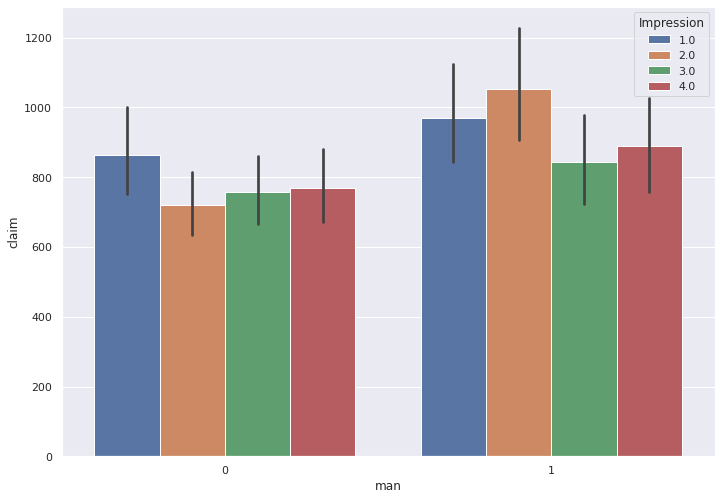

In [ ]:
# Mixing gender and Impressions

sns.barplot(x = 'man', y = 'claim', hue = 'Impression' ,data = df2)

#### Age

In [ ]:
# Descriptive analysis with age feature

from datetime import date
df2['age']= date.today().year - df2.birthyear
df2.head(5)

,man,birthyear,claim,number_items_reported,Impression,Impression1,Impression2,Impression3,Impression4,age
0,0,1977,110.0,1,3.0,0,0,1,0,45
1,0,1987,12.0,1,3.0,0,0,1,0,35
2,1,1982,628.0,1,1.0,1,0,0,0,40
3,1,1968,503.6,1,1.0,1,0,0,0,54
4,1,1980,807.8,3,3.0,0,0,1,0,42


In [ ]:
df2['age'].describe()

count    1500.000000
mean       47.285333
std        12.722729
min        19.000000
25%        37.000000
50%        48.000000
75%        56.000000
max        88.000000
Name: age, dtype: float64

In [ ]:
# Formatting age to create bins in order to create categorical variables.


def format_fn(x): 
    if x < 30:
        return '<30'
    elif x <40:
        return '<40'
    elif x< 50:
        return '<50'
    elif x< 60:
        return '<60'
    elif x< 70:
        return '<70'
    else:
        return '>=70'

df2['age_cat']=df2['age'].apply(format_fn)
df2 = df2.sort_values(by=['age_cat'])

# Variable analysis: avergae claim by age bin
df2.claim.groupby(df2.age_cat).mean()

age_cat
<30      795.762500
<40      803.401394
<50      821.358594
<60      859.797343
<70      887.235294
>=70    1104.272881
Name: claim, dtype: float64

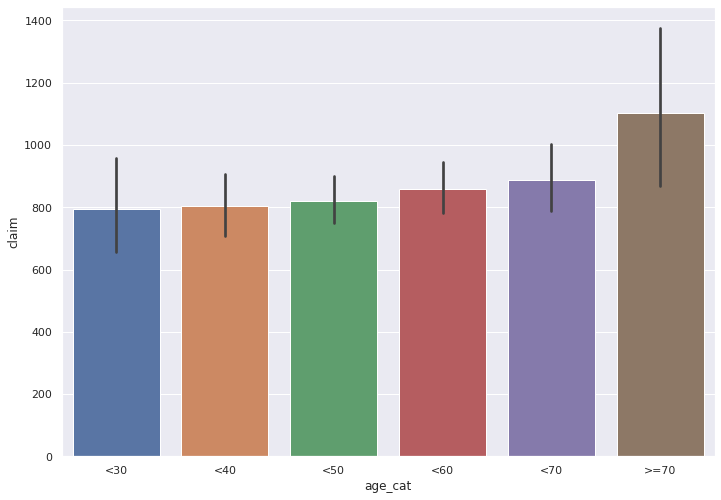

In [ ]:
# Visalisation: avergae claim by age bin

sns.barplot(x='age_cat', y='claim' ,data=df2)

Text(0.5, 1.0, 'Claim size distribution according to the age')

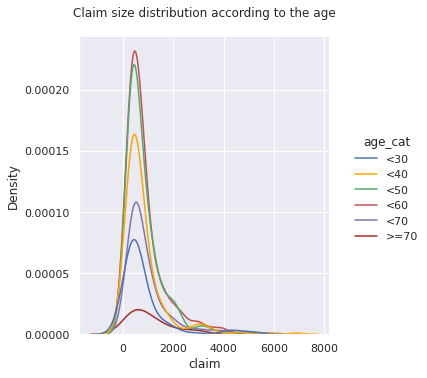

In [ ]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.displot(data=df2, x=df2['claim'], hue=df2['age_cat'], kind="kde", palette = ['b','orange','g','r','m','brown'])

plt.title('Claim size distribution according to the age', pad=20)

In [ ]:
# Regression with age bins and OLS method

df2[['<30','<40','<50','<60','<70','>=70']] = pd.get_dummies(df2['age_cat'])
x_age = sm.add_constant(df2[['<40','<50','<60','<70','>=70']])
y_age = df2['claim']
lr_age = sm.OLS(y_age, x_age).fit()
lr_age.summary()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claim   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.542
Date:                Wed, 31 Aug 2022   Prob (F-statistic):              0.174
Time:                        17:48:23   Log-Likelihood:                -12234.
No. Observations:                1500   AIC:                         2.448e+04
Df Residuals:                    1494   BIC:                         2.451e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        795.7625     68.509     11.615      0.000     661.378     930.147
<40            7.6389     84.731      0.090      0.928    -158.565     173.842
<50           25.5961     80.940      0.316      0.752    -133.173     184.365
<60           64.0348     80.104      0.799      0.424     -93.094     221.164
<70           91.4728     90.502      1.011      0.312     -86.052     268.997
>=70         308.5104    129.558      2.381      0.017      54.376     562.645
==============================================================================
Omnibus:                      875.881   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7203.620
Skew:                           2.676   Prob(JB):                         0.00
Kurtosis:                      12.306   Cond. No.                         9.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### All variables

In [ ]:
# Fitting a regression with all variables in order to have a model overview

x_all = sm.add_constant(df2[['man','number_items_reported','Impression2','Impression3','Impression4','age']])
y_all = df2['claim']
lr_all = sm.OLS(y_all,x_all).fit()
lr_all.summary()


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claim   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     10.75
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           1.00e-11
Time:                        19:10:16   Log-Likelihood:                -12206.
No. Observations:                1500   AIC:                         2.443e+04
Df Residuals:                    1493   BIC:                         2.446e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   556.6270     94.720      5.877      0.000     370.829     742.425
man                     145.0796     43.773      3.314      0.001      59.217     230.943
number_items_reported    77.7308     11.757      6.612      0.000      54.670     100.792
Impression2             -14.1339     61.556     -0.230      0.818    -134.880     106.612
Impression3            -100.7708     60.692     -1.660      0.097    -219.821      18.280
Impression4             -75.1698     59.902     -1.255      0.210    -192.671      42.332
age                       2.6535      1.700      1.561      0.119      -0.680       5.988
==============================================================================
Omnibus:                      913.429   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8318.275
Skew:                           2.785   Prob(JB):                         0.00
Kurtosis:                      13.103   Cond. No.                         249.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the regression above we can see that the gender is statistically significant. Whereas for the variable age, it is not significant and therefore should not be taken into account in the model. And an another time we can see that the Impression3 is statistically significant at 10 % and reduce claim amount. 

## 2.3. Advices (c) <a name='heading--2-3'>

Regarding the analysis conducted, we advice the manager to move forward with the third Impression (i.e. 'a mild warning about not to “overreport”') because this impression has the lowest coefficient of regression and seems to have a real impact in reducing the claim amount. 


## 2.4. Other outcomes (d) <a name='heading--2-4'>

In [ ]:
# Having a look into the number of items reported to see if it is correlated

df2.Impression.groupby(df2.number_items_reported).mean()

number_items_reported
1     2.541913
2     2.560563
3     2.421769
4     2.352941
5     2.321429
6     2.800000
7     2.142857
8     3.666667
9     2.000000
10    1.500000
11    2.333333
12    3.000000
13    3.000000
14    2.500000
17    2.000000
18    1.000000
19    4.000000
Name: Impression, dtype: float64

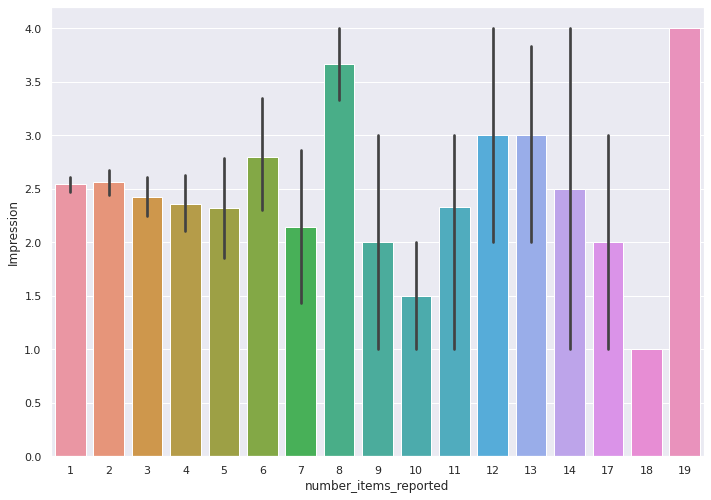

In [ ]:
sns.barplot(x='number_items_reported', y='Impression' ,data=df2)

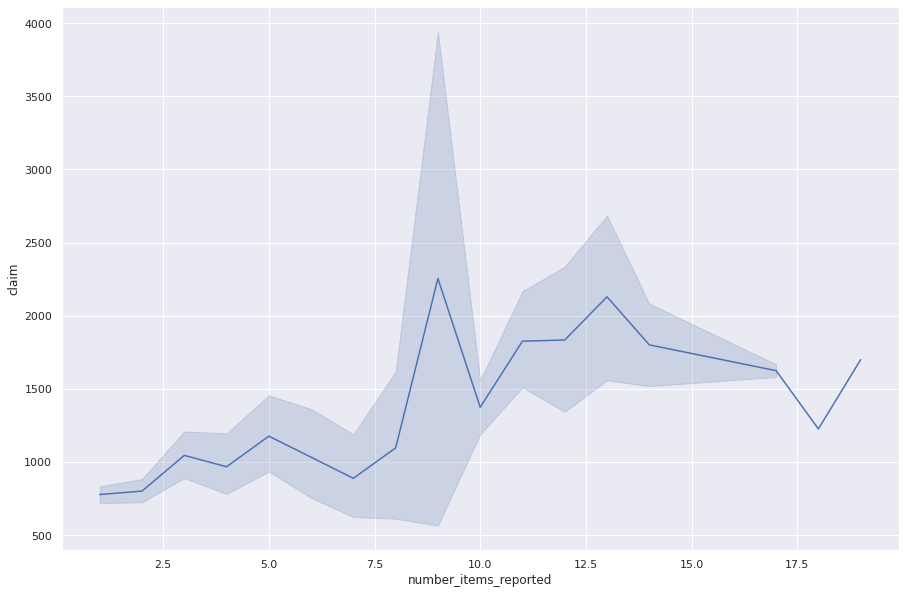

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x='number_items_reported', y='claim' ,data=df2)

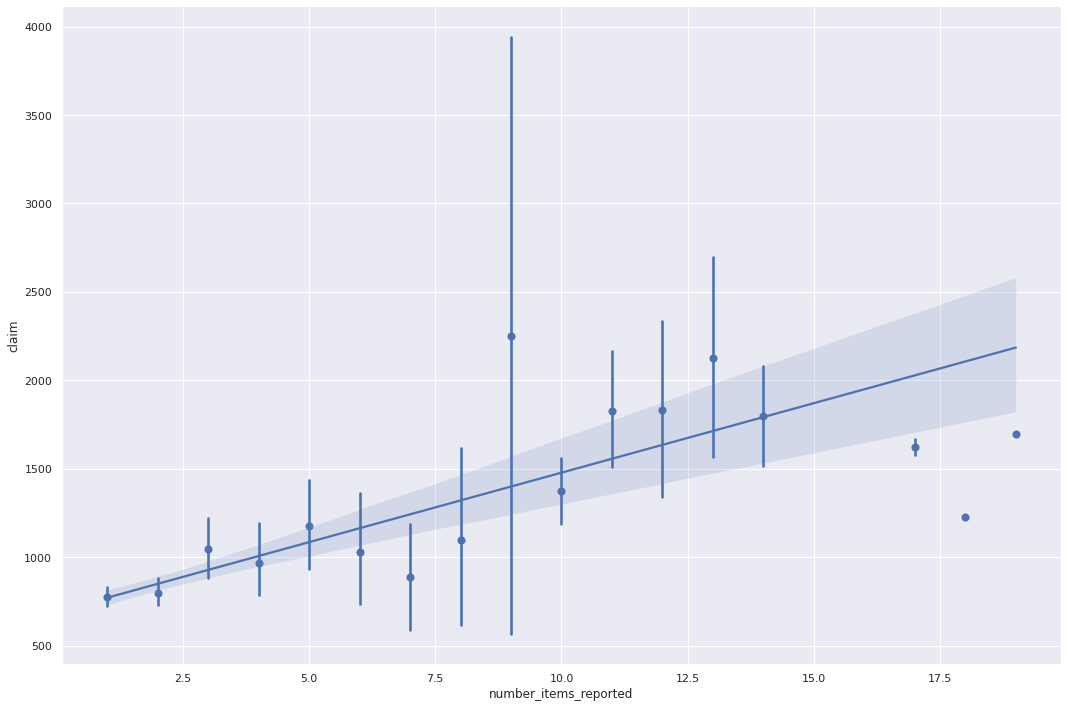

In [ ]:
sns.lmplot(x='number_items_reported', y='claim' ,data=df2 ,x_estimator=np.mean,height=10, aspect=15/10)

From the graphs above there seems to be a positive correlation between the claims and number of items reported. Although, it should be considered that for number of items higher than 17 there is not enough data to explain it. Also, our prime analysis should be about which Impression to show to the client in order to reduce claims so this last analysis is not precise but could be a first point for further analysis in the company. Let's see if there is any correlation between the number of items reported and the the Impression shown to the client. 

In [ ]:
x_number = sm.add_constant(df2[['Impression']])
y_number = df2['number_items_reported']
lr_number = sm.OLS(y_number,x_number).fit()
lr_number.summary()


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     number_items_reported   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.001
Method:                    Least Squares   F-statistic:                   0.05695
Date:                   Wed, 31 Aug 2022   Prob (F-statistic):              0.811
Time:                           19:18:19   Log-Likelihood:                -3031.6
No. Observations:                   1500   AIC:                             6067.
Df Residuals:                       1498   BIC:                             6078.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9659      0.116     16.995      0.000       1.739       2.193
Impression    -0.0100      0.042     -0.239      0.811      -0.092       0.072
==============================================================================
Omnibus:                     1363.171   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44804.718
Skew:                           4.275   Prob(JB):                         0.00
Kurtosis:                      28.372   Cond. No.                         7.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No, this regression model does not highlight important correlations between these variables. 